In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the Data
df = pd.read_csv('FTSE Malaysia KLCI Historical Data (2).csv')

# 2. Fix the "Date" Column
# LSTMs need oldest to newest to learn the sequence of time.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# 3. Fix the "Price", "Open", "High", "Low" Columns
# They are strings with commas, we need to remove ',' and turn them into numbers.
cols_to_fix = ['Price', 'Open', 'High', 'Low']
for col in cols_to_fix:
    # Remove comma and convert to float
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 4. Fix the Colume Column
# It has "M" for Millions and "K" for Thousands
def clean_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x == '-': return 0
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
    return float(x)

df['Vol.'] = df['Vol.'].apply(clean_volume)

# 5.
# Remove the '%' sign and convert to float
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Check if it works
print("Data Cleaned Successfully")
print(df.info())
print(df.head())

Data Cleaned Successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2451 non-null   datetime64[ns]
 1   Price     2451 non-null   float64       
 2   Open      2451 non-null   float64       
 3   High      2451 non-null   float64       
 4   Low       2451 non-null   float64       
 5   Vol.      2450 non-null   float64       
 6   Change %  2451 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 134.2 KB
None
        Date    Price     Open     High      Low         Vol.  Change %
0 2015-11-19  1660.06  1657.09  1664.30  1655.99  109630000.0      0.21
1 2015-11-20  1661.89  1660.17  1663.48  1657.13  104970000.0      0.11
2 2015-11-23  1670.90  1661.59  1673.92  1661.59  106120000.0      0.54
3 2015-11-24  1677.03  1678.68  1686.69  1677.03  142980000.0      0.37
4 2015-11-25  1684.42  1672.

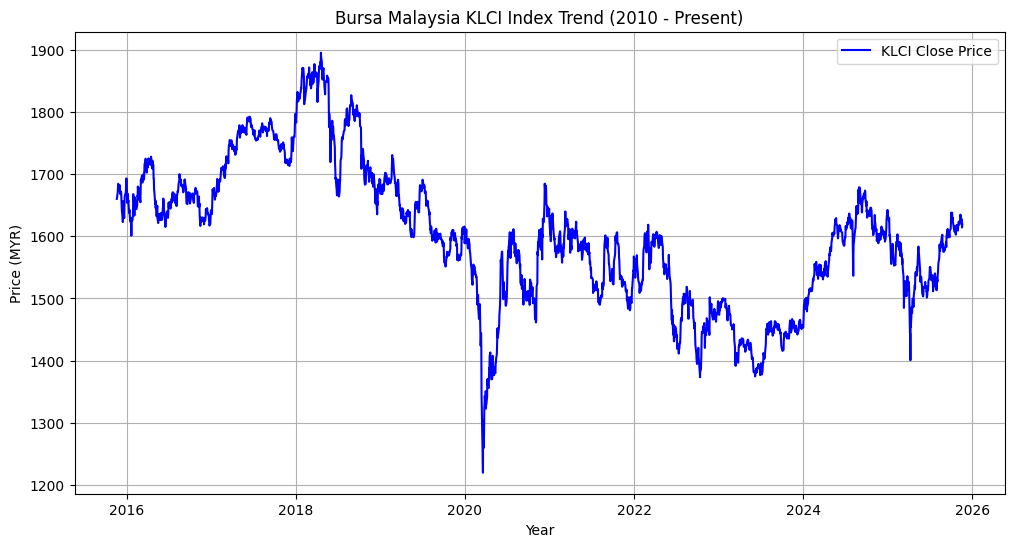

In [ ]:
# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='KLCI Close Price', color='blue')
plt.title('Bursa Malaysia KLCI Index Trend (2010 - Present)')
plt.xlabel('Year')
plt.ylabel('Price (MYR)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Select the Target Column
# We are forecasting the 'Price' (Closing Price)
data = df['Price'].values.reshape(-1, 1)

# 2. Normalize the Data
# The paper specifically uses Min-Max Normalization to scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Define the Sliding Window Function
# This converts a simple list of numbers into a format LSTM can learn:
# Input (X): Day 1 to Day 20
# Output (y): Day 21
def create_dataset(dataset, look_back=20):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 4. Apply the Window
# The research paper found a look-back of 20 days gave the best results
look_back = 20
X, y = create_dataset(scaled_data, look_back)

# 5. Split into Training and Testing
# The paper used a 70% Training / 30% Testing split
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# 6. Reshape for LSTM
# LSTM needs 3D input: [Samples, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (1701, 20, 1)
Testing Data Shape: (730, 20, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0670 - val_loss: 0.0069
Epoch 2/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 3/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 7.9425e-04
Epoch 4/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 7.6106e-04
Epoch 5/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 7.4937e-04
Epoch 6/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 7.6531e-04
Epoch 7/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 7.3608e-04
Epoch 8/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 7.4512e-04
Epoch 9/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 7.4311e-04
Epoch 10/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 7.0609e-04
Epoch 11/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 6.6869e-04
Epoch 12/64
27/27 ━━━━━━━━━━━━━━━━━━

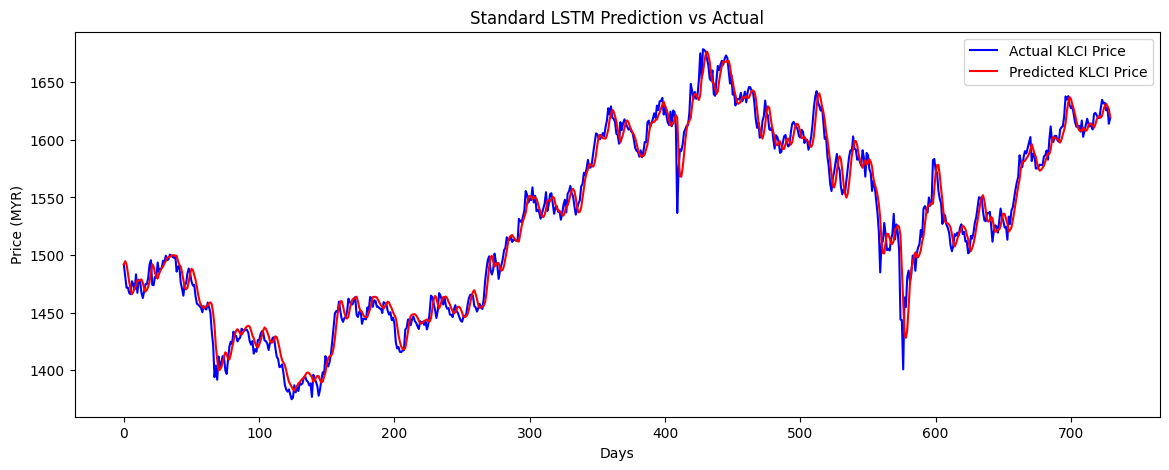

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Define the Standard LSTM Model Structure
# (Parameters taken from Table 1 of the paper)
model = Sequential()

# Layer 1: 100 Neurons, return_sequences=True because there is another LSTM layer after this
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Layer 2: 20 Neurons, return_sequences=False because next is the output layer
model.add(LSTM(units=20, return_sequences=False))

# Output Layer: Predicts 1 value (the Stock Price)
model.add(Dense(units=1))

# 2. Compile the Model
# The paper uses Learning Rate of 0.001 and MSE loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 3. Train the Model
# The paper specifies Epochs=64 and Batch_size=64
history = model.fit(
    X_train, y_train,
    epochs=64,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# 4. Make Predictions
predictions = model.predict(X_test)

# 5. Inverse Transform (Convert '0.55' back to '1600 MYR')
# We utilize the scaler created in the previous step
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Evaluation Metrics
# Calculate RMSE, MAE, MAPE, and R2 as used in the paper
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_actual, predictions_actual)

print(f"\n--- Standard LSTM Results ---")
print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")
print(f"MAPE: {mape}%")
print(f"R2:   {r2}")

# 7. Plot the Results
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual KLCI Price')
plt.plot(predictions_actual, color='red', label='Predicted KLCI Price')
plt.title('Standard LSTM Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Price (MYR)')
plt.legend()
plt.show()

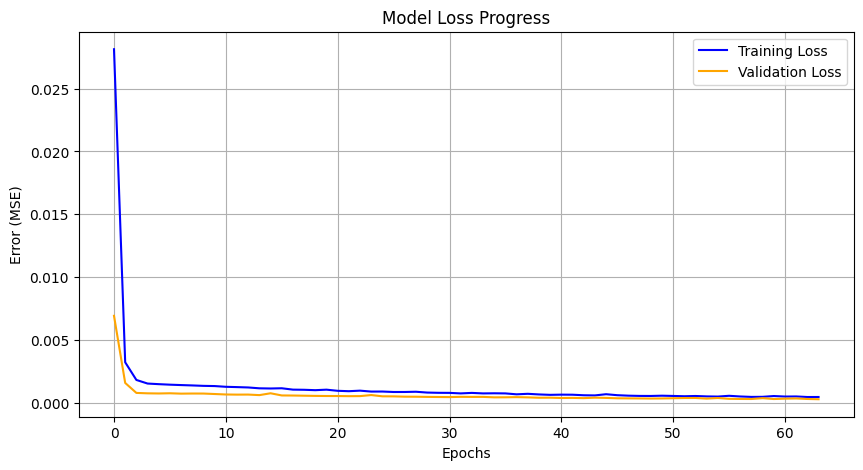

In [ ]:
# Plot Training Loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Progress')
plt.ylabel('Error (MSE)')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Predict on Training Data
train_predictions = model.predict(X_train)
train_predictions_actual = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# 2. Calculate Metrics for Training
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))

# 3. Compare with Testing Metrics from previous step
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing  RMSE: {rmse:.2f}")

if train_rmse < (rmse * 0.5):
    print("\Possible Overfitting detected (Training error is much lower than Testing error)")
else:
    print("\nSTATUS: Model looks healthy (Training and Testing errors are balanced).")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training RMSE: 14.00
Testing  RMSE: 11.55

STATUS: Model looks healthy (Training and Testing errors are balanced).


In [ ]:
# Fitness Function for PSO

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import math

# Define bounds for the parameters (from the paper)
# [Node1, Node2, Epochs, Learning Rate]
bounds = [
    (10, 200),    # Node1 (Integers)
    (10, 200),    # Node2 (Integers)
    (10, 100),    # Epochs (Integers) - Limited to 100 for speed in this demo
    (0.001, 0.01) # Learning Rate (Float)
]

def train_evaluate_lstm(params):
    # 1. Unpack parameters
    n_nodes1 = int(params[0])
    n_nodes2 = int(params[1])
    n_epochs = int(params[2])
    learning_rate = params[3]

    # 2. Build Model
    model = Sequential()
    model.add(LSTM(units=n_nodes1, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=n_nodes2, return_sequences=False))
    model.add(Dense(units=1))

    # 3. Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # 4. Train (Turn off verbose to keep output clean)
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=64, verbose=0)

    # 5. Evaluate
    predictions = model.predict(X_test, verbose=0)

    # Inverse transform to get real error
    predictions_actual = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = math.sqrt(mean_squared_error(y_test_actual, predictions_actual))

    print(f"Tried Params: {n_nodes1}, {n_nodes2}, {n_epochs}, {learning_rate:.5f} -> RMSE: {rmse:.2f}")
    return rmse

In [ ]:
import random

def pso_optimization(fitness_function, bounds, num_particles=3, iterations=3):
    dim = len(bounds)

    # PSO Hyperparameters (from the paper)
    w = 0.6    # Inertia weight
    c1 = 1.5   # Cognitive (Self) weight
    c2 = 1.5   # Social (Swarm) weight

    # Initialize Swarm
    swarm = []
    velocities = []
    pbest_pos = []
    pbest_score = []

    # Random initialization
    for _ in range(num_particles):
        particle = []
        velocity = []
        for i in range(dim):
            # Random position within bounds
            if i < 3: # Integer parameters
                pos = random.randint(bounds[i][0], bounds[i][1])
            else:     # Float parameter
                pos = random.uniform(bounds[i][0], bounds[i][1])
            particle.append(pos)
            velocity.append(0.1 * pos) # Small initial velocity

        swarm.append(particle)
        velocities.append(velocity)
        pbest_pos.append(particle)
        pbest_score.append(float('inf'))

    gbest_pos = swarm[0]
    gbest_score = float('inf')

    print("Starting PSO Optimization")

    # Optimization Loop
    for it in range(iterations):
        print(f"\nIteration {it+1}/{iterations}")

        for i in range(num_particles):
            # 1. Evaluate Fitness
            current_pos = swarm[i]
            score = fitness_function(current_pos)

            # 2. Update Personal Best
            if score < pbest_score[i]:
                pbest_score[i] = score
                pbest_pos[i] = current_pos

            # 3. Update Global Best
            if score < gbest_score:
                gbest_score = score
                gbest_pos = current_pos
                print(f"  >>> New Global Best Found! RMSE: {gbest_score:.2f}")

        # 4. Update Velocity and Position
        for i in range(num_particles):
            new_velocity = []
            new_pos = []
            for d in range(dim):
                r1 = random.random()
                r2 = random.random()

                # Velocity Update Equation
                vel = (w * velocities[i][d]) + \
                      (c1 * r1 * (pbest_pos[i][d] - swarm[i][d])) + \
                      (c2 * r2 * (gbest_pos[d] - swarm[i][d]))
                new_velocity.append(vel)

                # Position Update Equation
                pos = swarm[i][d] + vel

                # Enforce Bounds (Keep particles inside the search space)
                if pos < bounds[d][0]: pos = bounds[d][0]
                if pos > bounds[d][1]: pos = bounds[d][1]

                new_pos.append(pos)

            velocities[i] = new_velocity
            swarm[i] = new_pos

    return gbest_pos, gbest_score

# Run the PSO
best_params, best_rmse = pso_optimization(train_evaluate_lstm, bounds, num_particles=3, iterations=3)

print(f"\nOPTIMIZATION COMPLETE")
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: Nodes1={int(best_params[0])}, Nodes2={int(best_params[1])}, Epochs={int(best_params[2])}, LR={best_params[3]:.5f}")

--- Starting PSO Optimization ---

Iteration 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 90, 154, 22, 0.00535 -> RMSE: 12.81
  >>> New Global Best Found! RMSE: 12.81


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 83, 118, 41, 0.00502 -> RMSE: 12.45
  >>> New Global Best Found! RMSE: 12.45


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 56, 137, 92, 0.00588 -> RMSE: 10.28
  >>> New Global Best Found! RMSE: 10.28

Iteration 2/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 79, 138, 83, 0.00601 -> RMSE: 12.50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 67, 152, 60, 0.00537 -> RMSE: 9.78
  >>> New Global Best Found! RMSE: 9.78


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 59, 145, 97, 0.00623 -> RMSE: 12.22

Iteration 3/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 61, 135, 90, 0.00580 -> RMSE: 9.41
  >>> New Global Best Found! RMSE: 9.41


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 57, 172, 72, 0.00558 -> RMSE: 9.47


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tried Params: 64, 147, 79, 0.00617 -> RMSE: 9.77

OPTIMIZATION COMPLETE
Best RMSE: 9.408527727905085
Best Parameters: Nodes1=61, Nodes2=135, Epochs=90, LR=0.00580


Training Final PSO-Optimized Model with: 61 nodes, 135 nodes, 90 epochs, 0.00580 LR
Epoch 1/90


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0748
Epoch 2/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 3/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 4/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2870e-04
Epoch 5/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2679e-04
Epoch 6/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5762e-04
Epoch 7/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1095e-04
Epoch 8/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8637e-04
Epoch 9/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0727e-04
Epoch 10/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2083e-04
Epoch 11/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2841e-04
Epoch 12/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1441e-04
Epoch 13/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6413e-04
Epoch 14/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0258e-04
Epoch 15/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

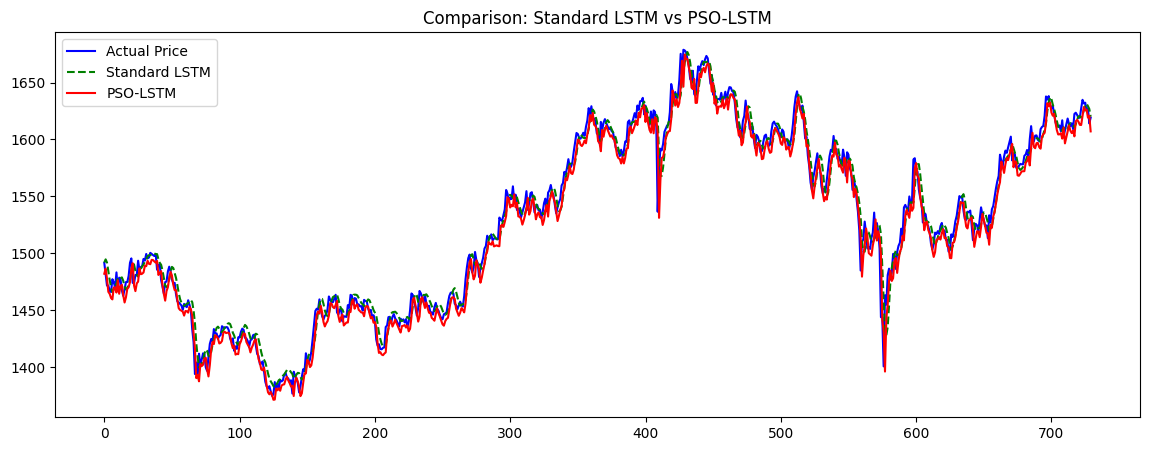

In [ ]:
# Reveal the best parameters found by PSO
final_nodes1 = int(best_params[0])
final_nodes2 = int(best_params[1])
final_epochs = int(best_params[2])
final_lr = best_params[3]

print(f"Training Final PSO-Optimized Model with: {final_nodes1} nodes, {final_nodes2} nodes, {final_epochs} epochs, {final_lr:.5f} LR")

# Build the Champion Model
pso_model = Sequential()
pso_model.add(LSTM(units=final_nodes1, return_sequences=True, input_shape=(X_train.shape[1], 1)))
pso_model.add(LSTM(units=final_nodes2, return_sequences=False))
pso_model.add(Dense(units=1))

optimizer = Adam(learning_rate=final_lr)
pso_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train
pso_model.fit(X_train, y_train, epochs=final_epochs, batch_size=64, verbose=1)

# Predict
pso_predictions = pso_model.predict(X_test)
pso_predictions_actual = scaler.inverse_transform(pso_predictions)

# Calculate Metrics
pso_rmse = math.sqrt(mean_squared_error(y_test_actual, pso_predictions_actual))
pso_mae = mean_absolute_error(y_test_actual, pso_predictions_actual)
pso_mape = np.mean(np.abs((y_test_actual - pso_predictions_actual) / y_test_actual)) * 100
pso_r2 = r2_score(y_test_actual, pso_predictions_actual)

print(f"\n--- PSO-Optimized LSTM Results ---")
print(f"RMSE: {pso_rmse:.2f}")  # formatted to 2 decimal places for cleaner output
print(f"MAE:  {pso_mae:.2f}")
print(f"MAPE: {pso_mape:.2f}%")
print(f"R2:   {pso_r2:.4f}")

# Final Comparison Plot
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual Price')

if 'predictions_actual' in locals():
    plt.plot(predictions_actual, color='green', linestyle='--', label='Standard LSTM')
plt.plot(pso_predictions_actual, color='red', label='PSO-LSTM')
plt.title('Comparison: Standard LSTM vs PSO-LSTM')
plt.legend()
plt.show()

Retraining Optimized Model with: 61 nodes, 135 nodes, 90 epochs, 0.0058 LR
Epoch 1/90


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0694 - val_loss: 0.0027
Epoch 2/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 5.4971e-04
Epoch 3/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 5.1026e-04
Epoch 4/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 5.4352e-04
Epoch 5/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1371e-04 - val_loss: 6.7916e-04
Epoch 6/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2818e-04 - val_loss: 6.0824e-04
Epoch 7/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3646e-04 - val_loss: 4.2452e-04
Epoch 8/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2574e-04 - val_loss: 5.0196e-04
Epoch 9/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5230e-04 - val_loss: 4.1285e-04
Epoch 10/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0555e-04 - val_loss: 4.1348e-04
Epoch 11/90
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5770e-04 - val_loss: 3.7328e-04
Epoch 12/90
27

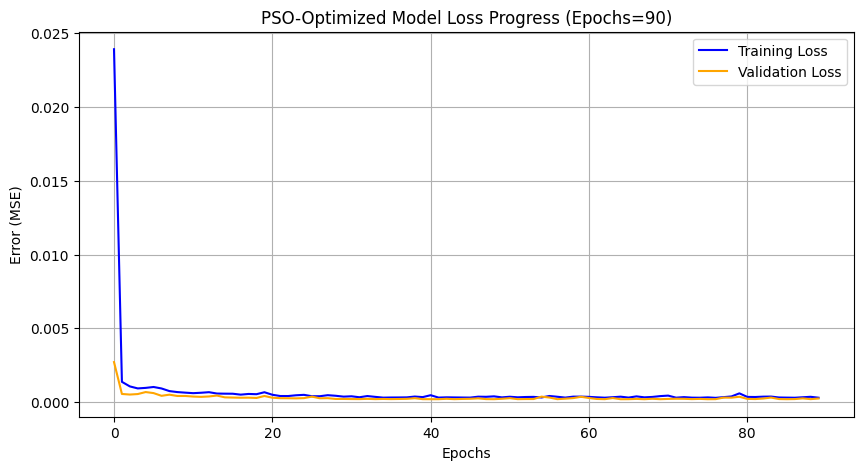

Final Training Loss: 0.00030
Final Validation Loss: 0.00024
STATUS: The model looks healthy (Training and Validation track closely).


In [ ]:
import matplotlib.pyplot as plt

# 1. Use the best parameters just found

best_nodes1 = 61
best_nodes2 = 135
best_epochs = 90
best_lr = 0.00580

print(f"Retraining Optimized Model with: {best_nodes1} nodes, {best_nodes2} nodes, {best_epochs} epochs, {best_lr} LR")

# 2. Re-build the model structure
pso_model = Sequential()
pso_model.add(LSTM(units=best_nodes1, return_sequences=True, input_shape=(X_train.shape[1], 1)))
pso_model.add(LSTM(units=best_nodes2, return_sequences=False))
pso_model.add(Dense(units=1))

# 3. Compile with the specific Learning Rate
optimizer = Adam(learning_rate=best_lr)
pso_model.compile(optimizer=optimizer, loss='mean_squared_error')

# 4. Train AND save the history
history_pso = pso_model.fit(
    X_train, y_train,
    epochs=best_epochs,
    batch_size=64,
    validation_data=(X_test, y_test), # We need this to check overfitting
    verbose=1
)

# 5. Plot the Loss Curves (Standard vs Optimized)
plt.figure(figsize=(10, 5))
plt.plot(history_pso.history['loss'], label='Training Loss', color='blue')
plt.plot(history_pso.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'PSO-Optimized Model Loss Progress (Epochs={best_epochs})')
plt.ylabel('Error (MSE)')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Check for Overfitting numerically
train_loss = history_pso.history['loss'][-1]
val_loss = history_pso.history['val_loss'][-1]
print(f"Final Training Loss: {train_loss:.5f}")
print(f"Final Validation Loss: {val_loss:.5f}")

if train_loss < (val_loss * 0.5):
    print("WARNING: The Validation Loss is much higher than Training Loss. Possible Overfitting.")
else:
    print("STATUS: The model looks healthy (Training and Validation track closely).")